In [79]:
# ref: https://www.kaggle.com/ekababisong/credit-card-fraud-detection-using-xgboost/notebook?scriptVersionId=986452

In [80]:
# import packages
print(__doc__)
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

import keras
from keras.layers import Input, Dense
from keras.models import Model

Automatically created module for IPython interactive environment


In [81]:
# mac Initializing libiomp5.dylib, but found libiomp5.dylib already initialized
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [82]:
# unexpected crash
# xgboost & matplotlib can

# brew uninstall libiomp clang-omp
# brew install gcc@5
# export CC = gcc-5

In [83]:
# load the data
dataframe = pd.read_csv("../data/creditcard.csv")
# dataframe = np.genfromtxt("../data/creditcard.csv", delimiter=',')

print(dataframe.shape)

# print("cvs shape: (row: %d" & (dataframe.shape[0]))
print("csv shape: (row: %d, column: %d)" % (dataframe.shape[0], dataframe.shape[1]))

(284807, 31)
csv shape: (row: 284807, column: 31)


In [84]:
# get column names
colNames = dataframe.columns.values
colNames

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class'], dtype=object)

In [85]:
# get dataframe dimensions
print ("Dimension of dataset:", dataframe.shape)

Dimension of dataset: (284807, 31)


In [86]:
# get attribute summaries
print(dataframe.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.165980e-15  3.416908e-16 -1.373150e-15  2.086869e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.490107e-15 -5.556467e-16  1.177556e-16 -2.406455e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [87]:
# get class distribution
print ("Normal transaction:", dataframe['Class'][dataframe['Class'] == 0].count()) #class = 0
print ("Fraudulent transaction:", dataframe['Class'][dataframe['Class'] == 1].count()) #class = 1

Normal transaction: 284315
Fraudulent transaction: 492


In [88]:
# separate classes into different datasets
class0 = dataframe.query('Class == 0')
class1 = dataframe.query('Class == 1')

# randomize the datasets
class0 = class0.sample(frac=1)
class1 = class1.sample(frac=1)

In [89]:
# undersample majority class due to class imbalance before training - train
class0train = class0.iloc[0:6000]
class1train = class1

# combine subset of different classes into one balaced dataframe
train = class0train.append(class1train, ignore_index=True).values

In [90]:
# split data into X and y
X = train[:,0:30].astype(float)
Y = train[:,30]

In [91]:
# XGBoost CV model
model = XGBClassifier()
kfold = StratifiedKFold(n_splits=10, random_state=7)

# use area under the precision-recall curve to show classification accuracy
scoring = 'roc_auc'
results = cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print( "AUC: %.3f (%.3f)" % (results.mean(), results.std()) )

AUC: 0.982 (0.012)


In [92]:
# change size of Matplotlib plot
fig_size = plt.rcParams["figure.figsize"] # Get current size

old_fig_params = fig_size
# new figure parameters
fig_size[0] = 12
fig_size[1] = 9
   
plt.rcParams["figure.figsize"] = fig_size # set new size

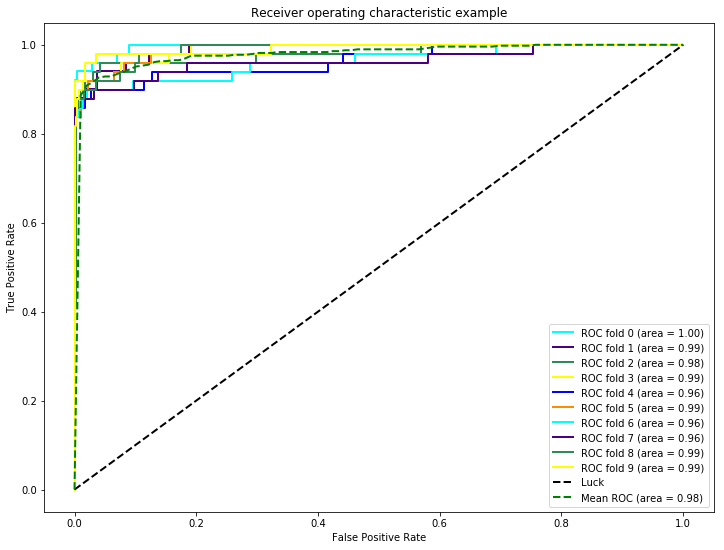

In [93]:
# plot roc-curve
# code adapted from http://scikit-learn.org
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(kfold.split(X, Y), colors):
    probas_ = model.fit(X[train], Y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= kfold.get_n_splits(X, Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()